# Shortest path

Bài toán: Tìm con đường ngắn nhất giữa 2 nodes. Và Chinese Postman Problem

---
SKIP THESE

In [1]:
import numpy as np
import networkx as nx
import pygraphviz as pgv
import graphviz as gv
from itertools import combinations

def render(G, engine='neato', weight_label=False):
    G = nx.drawing.nx_agraph.to_agraph(G)
    if weight_label is True:
        for e in G.edges():
            G.get_edge(e[0],e[1]).attr['label'] = G.get_edge(e[0],e[1]).attr['weight']
    return gv.Source(G.string(), engine=engine)

def chinese_postman(G):
    odd_nodes = [d[0] for d in list(G.degree) if d[1]%2==1]
    odd_deg_pairs_paths = [(m,n,
                    nx.shortest_path(G, source=m, target=n,weight='weight'),
                    nx.shortest_path_length(G, source=m, target=n,weight='weight') )
                    for m, n in combinations(odd_nodes, 2)]
    Gx = nx.MultiGraph(G)
    Gp = nx.Graph()
    
    for m,n,path,w in odd_deg_pairs_paths:
        Gp.add_edge(m, n, weight=1/w, path=path)
    # min weight matching
    best_matching = nx.Graph(list(nx.max_weight_matching(Gp)))
    for m, n in best_matching.edges():
        path = Gp[m][n]["path"]
        Gx.add_edges_from(nx.utils.pairwise(path))
    return Gx

def add_ct(G, start='start', end='end'):
    nG = G.copy()
    for n in nG.nodes:
        nG.nodes[n]['ct']= 0
    nG.nodes[end]['label'] = f"{end} pt:{nG.nodes[end]['pt']} ct:{nG.nodes[end]['ct']}"
    
    def recur(node):
        if node==start:
            return
        else:
            for n in list(nG.predecessors(node)):
                p_list = list(nG.successors(n))
                lst = [nG.nodes[p]['ct'] for p in p_list ]
                m = max (lst )
                pt = nG.nodes[n]['pt']
                ct = pt + m
                nG.nodes[n]['ct'] = ct
                nG.nodes[n]['label'] = f"{n} pt:{pt} ct:{ct}"
                recur(n)  
    recur(end)   
    return nG

END SKIP

---

# 1. Thuật toán Dijkstra
Input: Weighted connected simple graph G = (V, E) and vertices designated as Start and End.
Steps:
1. For each vertex x of G, assign a label L(x) so that L(x) = (−, 0) if x = Start and L(x) = (−, ∞) otherwise. Highlight Start.
2. Let u = Start and deﬁne F to be the neighbors of u. Update the labels for each vertex v in F as follows:
- if w(u) + w(uv) < w(v), then redeﬁne L(v) = (u, w(u) + w(uv))
- otherwise do not change L(v)
3. Highlight the vertex with lowest weight as well as the edge uv used to update the label. Redeﬁne u = v.
4. Repeat steps (2) and (3) until the ending vertex has been reached. In all future iterations, F consists of the un-highlighted neighbors of all previously highlighted vertices and the labels are updated only for those vertices that are adjacent to the last vertex that was highlighted.
5. The shortest path from Start to End is found by tracing back from End using the ﬁrst component of the labels. The total weight of the path is the weight for End given in the second component of its label.
Output: Highlighted path from Start to End and total weight w(End).

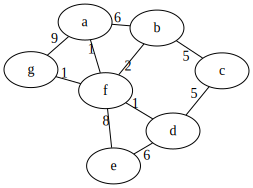

In [2]:
edges =  ['ab','bc','cd','de','ef','fg','ga','fa','fb','fd']
weights = [6,5,5,6,8,1,9,1,2,1]
G = nx.Graph(edges)
G.add_weighted_edges_from([(e[0],e[1],w) for e,w in zip(edges, weights)])
render(G, weight_label=True)

In [3]:
nx.shortest_path(G, source='g', target='c', weight='weight')

['g', 'f', 'd', 'c']

In [4]:
nx.shortest_path_length(G, source='g', target='c', weight='weight')

7

Thuật toán cũng áp dụng được cho DiGraph

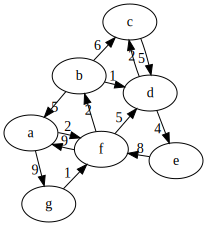

In [5]:
edges =  ['af','ag','ba','bc', 'bd','cd','de','dc','ef','fa','fb','fd','gf']
weights = [2,9,5,6,1,5,4,2,8,9,2,5,1]
G = nx.DiGraph(edges)
G.add_weighted_edges_from([(e[0],e[1],w) for e,w in zip(edges, weights)])
render(G, weight_label=True)

In [6]:
nx.shortest_path(G, 'g','c','weight')

['g', 'f', 'b', 'd', 'c']

In [7]:
nx.shortest_path_length(G, 'g','c','weight')

6

# 2. Chinese postman

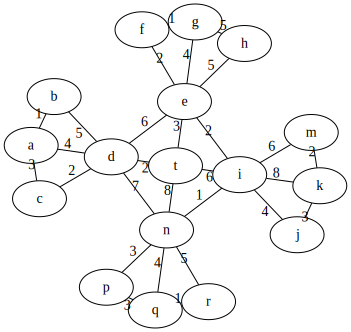

In [8]:
edges = [('a','b',1), ('a','c',3), ('a','d',4),
         ('d','b',5), ('c','d',2), ('d','n',7),
         ('d','t',2), ('d','e',6), ('t','n',8),
         ('t','e',3), ('n','i',1), ('t','i',6),
         ('e','i',2), ('n','p',3), ('n','r',5),
         ('n','q',4), ('r','q',1), ('q','p',3),
         ('f','e',2), ('f','g',1), ('e','g',4),
         ('e','h',5), ('g','h',5), ('i','m',6),
         ('i','j',4), ('i','k',8), ('m','k',2),
         ('j','k',3)        
        ]
G = nx.Graph()
G.add_weighted_edges_from(edges)
render(G, weight_label=True)

Thuật toán:
- Tìm ra odd nodes
- Pair từng node, ví dụ như hình trên là a-g,q-k hoặc a-k,q-g hoặc a-q,g-k
- Tìm ra shortest path của từng pair đó
- Tính min weight, sẽ ra path cần tìm

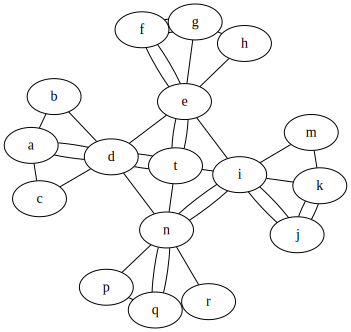

In [9]:
render(chinese_postman(G))

# 3. Directed Acyclic Graph (DAG) và task scheduling

DAG là graph có hướng mà các nodes sau không thể nào quay về các nodes trước.

## Definitions in task scheduling:
- Task: nodes. Label a, b, c,..
- Processor: is a unit or person who can complete tasks. Label P1, P2
- Four stages of a task: eligible, ineligible, in execution, completed. A task is eligible when all the tasks it relies upon are completed.
- Processing time: cost of task. Label pt(v) for task v.
- If task b relies on the completion of task a before it can be eligible, we call this a **precedence relationship.**
- Finish time: total weight.
- Optimal finish time, denoted OPT.

Ví dụ:
You are hosting a back to school party and a few friends have oﬀered to help with the preparations. You need to buy and cook the food, buy and put out the drinks (and you prefer to set up the ice buckets once the food is cooked so the drinks stay cold), dust and vacuum the house (and you always vacuum after the dusting), and set the table (which must be completed after the vacuuming and cooking is done). What is the best way to ﬁnish the preparations on time and with as little help as possible?

| Task | node| processing time | precedence</br>relationships |
|-|-|-|-|
|Buy food|f|40||
|Buy drinks|b|20||
|Dust|d|20||
|Vacuum| v| 30|d|
|Cook food| c | 60|f|
|Set out drinks|s|30|b,c|
|Set Table| t|20|v,c|

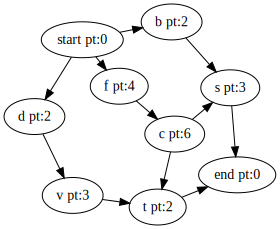

In [10]:
edges = [('start', 'b'), ('start', "f"), ('start',"d"),
         ('b','s'), ('f','c'), ('d','v'),
         ('c','s'), ('c','t'), ('v','t'),
         ('s','end'), ('t','end')]
nodes = [('start',0),('b',2), ('f',4),('d',2),('v',3),('c',6),('s',3),('t',2),('end',0)]
G = nx.DiGraph()
for n,a in nodes:
    G.add_node(n, pt=a, label=f"{n} pt:{a}")
G.add_edges_from(edges)
render(G)

In [11]:
nx.is_directed_acyclic_graph(G)

True

Đầu tiên mình thêm critical times cho mọi node  
ct(x) = pt(x) + max ( ct(successors(x))   )  
ct(end)=0

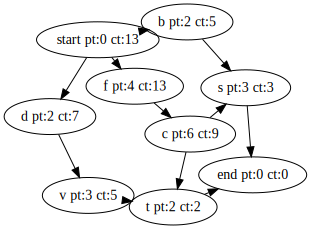

In [12]:
nG = add_ct(G)
render(nG)

Như render trên, ta có:
- critical path là path dài nhất: start - f - c - s -end
- critical path length = ct(start) = 13  
Trong nx có sẵn 2 thuật toán này

In [13]:
nx.dag_longest_path(G)

['start', 'f', 'c', 's', 'end']

In [14]:
nx.dag_longest_path_length(G)

4

Nhưng không cho ra được critical path priority list:
- critical path priority list: là reverse order của ct các nodes

In [15]:
sorted( [ (n, nG.nodes[n]['ct']) for n in nG.nodes] , key=lambda x: x[1] , reverse=True)

[('start', 13),
 ('f', 13),
 ('c', 9),
 ('d', 7),
 ('b', 5),
 ('v', 5),
 ('s', 3),
 ('t', 2),
 ('end', 0)]

Với critical path priority list = f-c-d-b-v-s-t, và 2 processors  
**Step 1: (T=0)** Since f is the ﬁrst item in the list, assign it to P1 . We cannot assign c to P2 since it relies on the completion of f. Moving to the next eligible task puts d into P2 .

|  |10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|
|- |  |  |  |  |  |  |  |  |  |   |   |   |   |   |   |
|P1| f| f| f| f|  |  |  |  |  |   |   |   |   |   |   |
|P2| d| d|  |  |  |  |  |  |  |   |   |   |   |   |   |

**Step 2: (T=20)** P2 has completed d and can be assigned a new task. Since f is still not complete, assign b, the next eligible task, to P2 .

|  |10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|
|- |  |  |  |  |  |  |  |  |  |   |   |   |   |   |   |
|P1| f| f| f| f|  |  |  |  |  |   |   |   |   |   |   |
|P2| d| d| b| b|  |  |  |  |  |   |   |   |   |   |   |

**Step 3: (T=40)** Both P1 and P2 can be assigned a new task. Task c is now eligible and will be assigned to P1 . The next eligible task is v; assign it to P2 .

|  |10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|
|- |  |  |  |  |  |  |  |  |  |   |   |   |   |   |   |
|P1| f| f| f| f| c| c| c| c| c|  c|   |   |   |   |   |
|P2| d| d| b| b| v| v| v|  |  |   |   |   |   |   |   |

**Step 4: (T=70)** P2 can be assigned a new task. However, all remaining tasks are ineligible since they rely on the completion of c. P2 remains idle.

|  |10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|
|- |  |  |  |  |  |  |  |  |  |   |   |   |   |   |   |
|P1| f| f| f| f| c| c| c| c| c|  c|   |   |   |   |   |
|P2| d| d| b| b| v| v| v| *| *|  *|   |   |   |   |   |

**Step 5: (T=100)** Both P1 and P2 can be assigned a new task. Since s is now eligible and ﬁrst in the priority list, it is assigned to P1 . Task t is also eligible and assigned to P2 .

|  |10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|
|- |  |  |  |  |  |  |  |  |  |   |   |   |   |   |   |
|P1| f| f| f| f| c| c| c| c| c|  c|  s|  s|  s|   |   |
|P2| d| d| b| b| v| v| v| *| *|  *|  t|  t|  *|   |   |

The schedule above has a ﬁnishing time of 130 minutes and contains 4 total hours of idle time.

## Tuy nhiên, critical priority không phải lúc nào cũng optimal, có 2 phép tính để tìm optimal time
- OPT >= ct(start)
- OPT >= sum(pt) / nums of processors

Ví dụ:

|Task              |Node | processing time | Precedence</br>Relationships|
|-                 |     |                 |                             |
|Buy plants        |b    |1                |                             |
|Remove bushes     |r    |7                |                             |
|Remove ivy        |i    |4                |                             |
|Weed flower beds  |w    |3                | b,r                         |
|Plant bushes      |p    |7                | b,r                         |
|Plant flowers     |f    |1                | w,p                         |
|Trim trees        |t    |4                | i                           |
|Mow and rake lawns|m    |6                | r                           |
|Install lighting  |l    |2                | w                           |

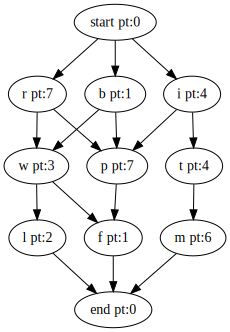

In [24]:
nodes = [('start',0),('b',1), ('r',7), ('i',4), ('w',3), ('p',7),
         ('f',1), ('t',4), ('m',6), ('l',2), ('end',0)]
edges = [('start','b'), ('start','r'), ('start','i'),
         ('b','w'), ('b','p'), ('r','w'), ('r','p'),
         ('i','p'),('i','t'),('w','l'),('w','f'),
         ('p','f'),('t','m'),('l','end'),('f','end'),('m','end')]
G = nx.DiGraph()
for n, pt in nodes:
    G.add_node(n,pt=pt, label=f"{n} pt:{pt}")
    
G.add_edges_from(edges)
render(G, engine='dot')

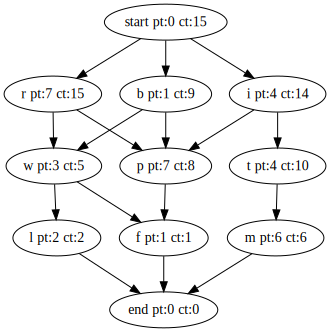

In [25]:
nG = add_ct(G)
render(nG, engine='dot')

In [27]:
nx.dag_longest_path(G) # có lẽ nx dùng weight edges =1

['start', 'b', 'w', 'l', 'end']

In [28]:
# critical path priority list
sorted( [ (n, nG.nodes[n]['ct']) for n in nG.nodes] , key=lambda x: x[1] , reverse=True)

[('start', 15),
 ('r', 15),
 ('i', 14),
 ('t', 10),
 ('b', 9),
 ('p', 8),
 ('m', 6),
 ('w', 5),
 ('l', 2),
 ('f', 1),
 ('end', 0)]

|  |1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|- | | | | | | | | | |  |  |  |  |  |  |  |  |  |  |
|P1|r|r|r|r|r|r|r|b|p| p| p| p| p| p| p|\*|\*| l| l|
|P2|i|i|i|i|t|t|t|t|m| m| m| m| m| m| w| w| w| f|\*|

In [29]:
# OPT is ct (start) = 15
# OPT with 2 processors
sum ( [nG.nodes[n]['pt'] for n in nG.nodes] )/ 2 

17.5

## Vậy OPT >= 18, optimal schedule là đây, bằng cách đặt w trước m

|  |1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|
|- | | | | | | | | | |  |  |  |  |  |  |  |  |  |
|P1|r|r|r|r|r|r|r|p|p| p| p| p| p| p| l| l| f|\*|
|P2|i|i|i|i|b|t|t|t|t| w| w| w| m| m| m| m| m| m|